In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import qtensor.states as states 
import qtensor.operators as ops
from qtensor.simulation.finiteTDVP import tdvp, right_mpo_contractions, gs_evolve
import qtensor.simulation.finiteTDVP as sim
import qtensor.thermofield as thf 
import qtensor.visualise as vis
import ncon

Basic state

In [2]:
N=32
D=10

psi = states.random_mps(N, 2, D, seed=42)
psi.right_canonical()

H = ops.tilted_ising(N=N)
H_terms = ops.extensive_as_terms(H).values()
H_term = ops.extensive_twosite_local_term(H, 3)

H_spin_up = ops.tilted_ising(J=0, h=1, g=0, N=N)


Simple TDVP

Method: method_exact, Time taken: 131.18 seconds


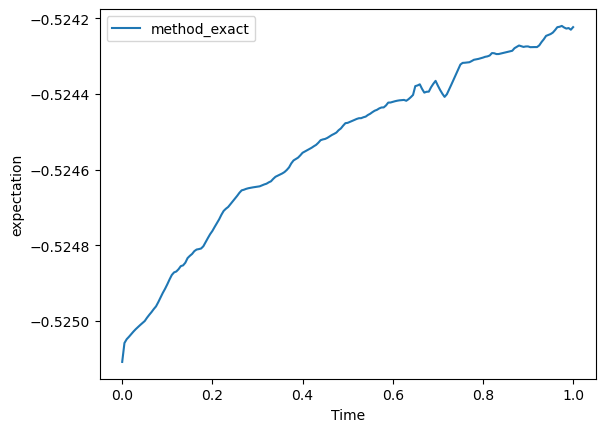

In [4]:
import time

t_f = 1
steps = 200
methods = [sim.method_exact]

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Time')
ax.set_ylabel('expectation')
for method in methods:
    psi_copy = copy.deepcopy(psi)
    ti = time.time()
    s_hist, _ = tdvp(psi_copy, H, t_f, steps, method=method, history=True)
    t_real = time.time() - ti
    print(f"Method: {str(method).split()[1]}, Time taken: {t_real:.2f} seconds")   
    t = list(s_hist.keys())
    expecs = [ops.local_expect(state, H_term) for state in s_hist.values()]
    ax.plot(t, expecs, label=str(method).split()[1])
ax.legend()


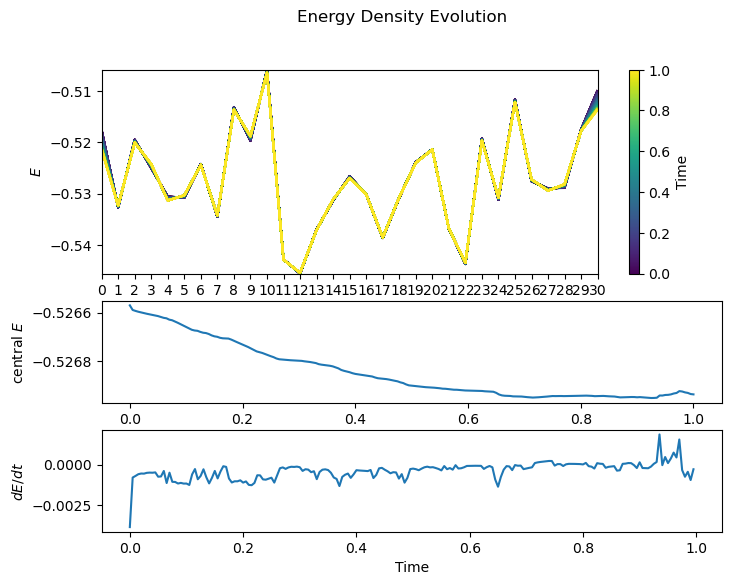

In [5]:
vis.plot_energy_density_evolution(s_hist, H_terms)

Ground state evolve

In [4]:
psi = gs_evolve(psi, H_spin_up, 1000, 100)

Intial energy: (-0.24798775449688892+4.1199682554448774e-17j)
Initiating TDVP
TDVP finished!
Final energy: (-9.99999981771035+9.360645398083498e-16j)


Thermofield stuff

In [5]:
N = 8
D = 8
H_usual = ops.tilted_ising(N=N)
beta = 1
H_th = thf.thermofield_hamiltonian(H_usual)


Intial energy: (-7.9589934546395655-8.371901976209293e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-23.99999999999999+2.1371793224034263e-15j)
Initiating TDVP
TDVP finished!
Energy at finite temperature: -7.627133944402408


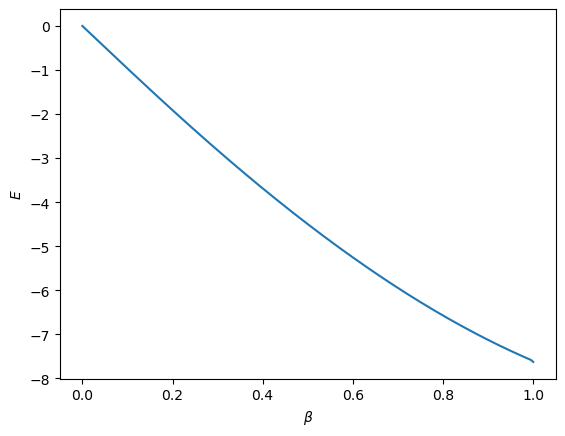

In [6]:
beta_psi, times, energies = thf.finite_T_thermofield(beta, N, D, H_th, steps=200)

In [7]:
# compare this to the groundstate energy
randpsi = states.random_mps(N, 2, D)
gs_evolve(randpsi, H_usual)

Intial energy: (-4.162048062445335-4.426325008087262e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-9.590983998497517+3.469446951953614e-16j)


Testing near thermal ansatz builder

In [40]:
N = 10
D = 4
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_middle = ops.extensive_twosite_local_term(H_tf, int((N-1)/2))

beta_avg = 0.05
delta_beta = 0.001
sigma = 1

In [41]:
inf_T_state = sim.inf_T_thermofield_variational(N, D, 1000, 100, seed=1)

Intial energy: (-8.586552795687586-3.0359969963153283e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-30+6.245004513516506e-16j)


Initiating TDVP
TDVP finished!
Energy at finite temperature: -0.6284824731320472


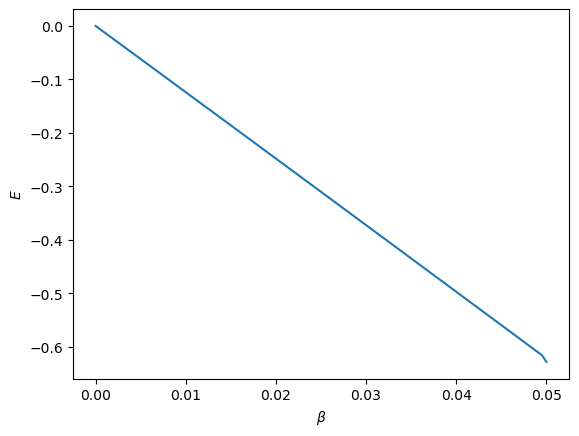

In [42]:
working_state = copy.deepcopy(inf_T_state)
even_state = thf.finite_T_thermofield(beta_avg, N, D, H_tf, initial_state=working_state)[0]

In [43]:
# gaussian profile ontop of an average, 
# with temp highest at centre,
# adjusted to have zero mean
# d_beta_profile = delta_beta*np.exp(-(np.linspace(-N/2, N/2, N)**2)/(2*sigma**2))

# cosine profile
k = 0.5
d_beta_profile = delta_beta*np.cos(-k*np.linspace(-N/2, N/2, N))

d_beta_profile = d_beta_profile - np.mean(d_beta_profile)*np.ones(N)

beta_profile = beta_avg*np.ones(N) - d_beta_profile
 
working_state = copy.deepcopy(inf_T_state)
profile_state = thf.near_thermal(H_tf, beta_profile, D, initial_state=working_state)

Initiating TDVP
TDVP finished!


In [ ]:
# Checking energy along chain
inft_energy = []
local_energy = []
even_energy = []
sites = sorted(list(H_usual.sites))
local_ops = ops.extensive_as_terms(H_tf).values()
for term in local_ops:
    inft_energy.append(ops.local_expect(inf_T_state, term))
    local_energy.append(ops.local_expect(profile_state, term))
    even_energy.append(ops.local_expect(even_state, term))

c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, 'Bond')

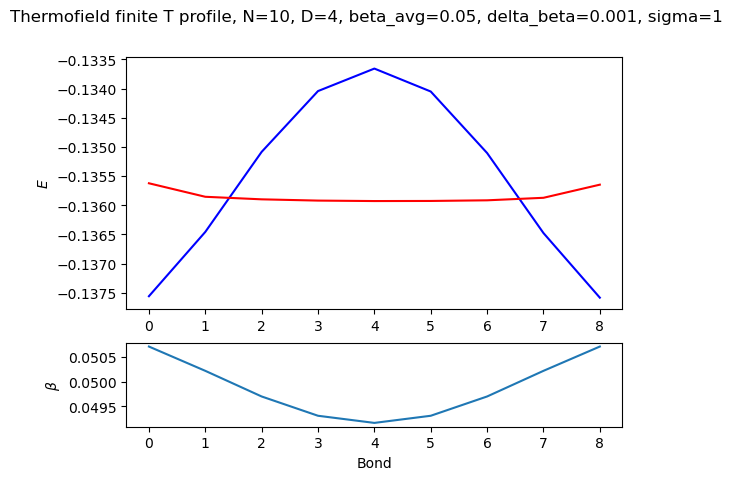

In [45]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1])
# ax[0,].plot(sites[:-1], inft_energy, color='k', label='Infinite T')
fig.suptitle(f"Thermofield finite T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b', label='Profile T')
ax[0,].plot(sites[:-1], even_energy, color='r', label='Finite T')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")

Do real time evolution on almost-thermal state

In [46]:
initial_state = copy.deepcopy(profile_state)
t_f = 0.5
n_steps = 50
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state,
 H_tf, t_f, n_steps, sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_tf, H_middle])


Initiating TDVP
t: 0.000
t: 0.010
t: 0.020
t: 0.030
t: 0.040
t: 0.050
t: 0.060
t: 0.070
t: 0.080
t: 0.090
t: 0.100
t: 0.110
t: 0.120
t: 0.130
t: 0.140
t: 0.150
t: 0.160
t: 0.170
t: 0.180
t: 0.190
t: 0.200
t: 0.210
t: 0.220
t: 0.230
t: 0.240
t: 0.250
t: 0.260
t: 0.270
t: 0.280
t: 0.290
t: 0.300
t: 0.310
t: 0.320
t: 0.330
t: 0.340
t: 0.350
t: 0.360
t: 0.370
t: 0.380
t: 0.390
t: 0.400
t: 0.410
t: 0.420
t: 0.430
t: 0.440
t: 0.450
t: 0.460
t: 0.470
t: 0.480
t: 0.490
t: 0.500
TDVP finished!


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

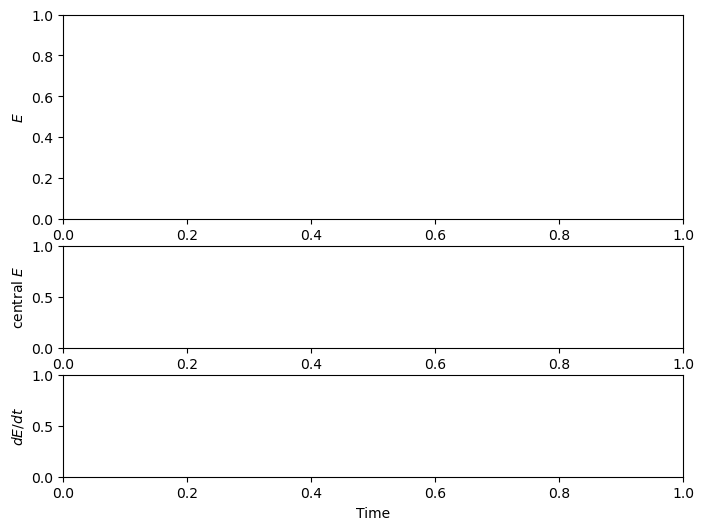

In [47]:
vis.plot_energy_density_evolution(evolved_state, local_ops)

Text(0.5, 0.98, 'Time-evolved T profile, N=24, D=8, beta_avg=0.05, delta_beta=0.001, sigma=1')

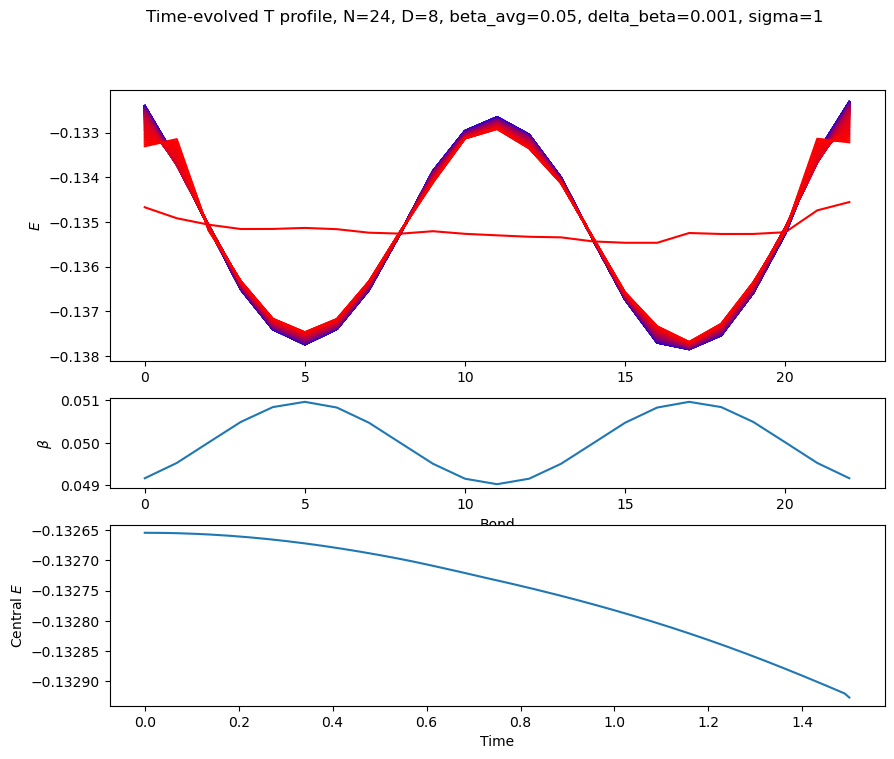

In [69]:
fig, ax = plt.subplots(3, 1, height_ratios=[3, 1, 2], figsize=(10, 8))
fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")
ax[0,].plot(sites[:-1], local_energy, color='b')
ax[0,].plot(sites[:-1], even_energy, color='r')
ax[0,].set_ylabel(r'$E$')
bond_profile = [np.sqrt(beta_profile[i]*beta_profile[i+1]) for i in range(N-1)]
ax[1,].plot(sites[:-1], bond_profile)
ax[1,].set_ylabel(r'$\beta$')
ax[1,].set_xlabel("Bond")


times = evolved_state.keys()
E_profile={}
for t in times:
    if t < 1.5:
        E_profile[t] = [ops.local_expect(evolved_state[t], op) for op in local_ops]
        ax[0,].plot(sites[:-1], E_profile[t], color=(t/t_f, 0, 1-t/t_f))


middle_energy = [expectations[t][1] for t in times]
ax[2,].plot(list(times)[:300], middle_energy[:300])
ax[2,].set_xlabel("Time")
ax[2,].set_ylabel(r'Central $E$')

fig.suptitle(f"Time-evolved T profile, N={N}, D={D}, beta_avg={beta_avg}, delta_beta={delta_beta}, sigma={sigma}")


Energy derivative

Text(0, 0.5, '$\\Delta E$')

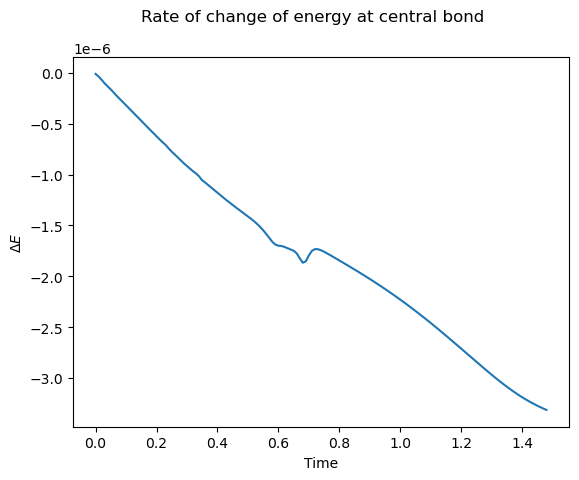

In [70]:
E_diff = np.array(middle_energy[1:]) - np.array(middle_energy[:-1])
fig, ax = plt.subplots(1, 1)
ax.plot(list(times)[:-2], E_diff[:-1])
fig.suptitle(f"Rate of change of energy at central bond")
ax.set_xlabel("Time")
ax.set_ylabel(r'$\Delta E$')

Creating Dictionary of temperatures an equillibrium energy density

In [ ]:
N = 8
D = 4
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_middle = ops.extensive_twosite_local_term(H_tf, int((N-1)/2))
H_terms = ops.extensive_as_terms(H_tf).values()

beta_max = 0.1
beta_range = np.linspace(0.01, beta_max, 11)
energies = {}

In [19]:
inf_T_state = sim.inf_T_thermofield_variational(N, D, 1000, 100, seed=1)

Intial energy: (-6.6221444045261375-1.1894156022472871e-15j)
Initiating TDVP
TDVP finished!
Final energy: (-24.00000000000002+2.7755575615628914e-17j)


Beta: 0.01
Initiating TDVP
TDVP finished!
Energy: (-0.013533678306705807-8.663431679016187e-19j)
Beta: 0.019000000000000003
Initiating TDVP


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


TDVP finished!
Energy: (-0.02574416924953331-1.0503328746426083e-18j)
Beta: 0.028000000000000004
Initiating TDVP
TDVP finished!
Energy: (-0.03798095964902794-2.0943817893253827e-18j)
Beta: 0.037000000000000005
Initiating TDVP
TDVP finished!
Energy: (-0.05024186074144674-5.8312035286717675e-19j)
Beta: 0.046000000000000006
Initiating TDVP
TDVP finished!
Energy: (-0.06252470803624981-9.62741071728575e-19j)
Beta: 0.05500000000000001
Initiating TDVP
TDVP finished!
Energy: (-0.07482736403061466+2.269919012535783e-19j)
Beta: 0.064
Initiating TDVP
TDVP finished!
Energy: (-0.08714772078308151+1.4526987869549054e-19j)
Beta: 0.073
Initiating TDVP
TDVP finished!
Energy: (-0.09948370222820074-1.837980837936661e-18j)
Beta: 0.082
Initiating TDVP
TDVP finished!
Energy: (-0.11183326638020949+1.2486746619695973e-18j)
Beta: 0.09100000000000001
Initiating TDVP
TDVP finished!
Energy: (-0.12419440725036837-5.797071604925445e-19j)
Beta: 0.1
Initiating TDVP
TDVP finished!
Energy: (-0.13656515655644974-5.29761

Text(0, 0.5, '$E$')

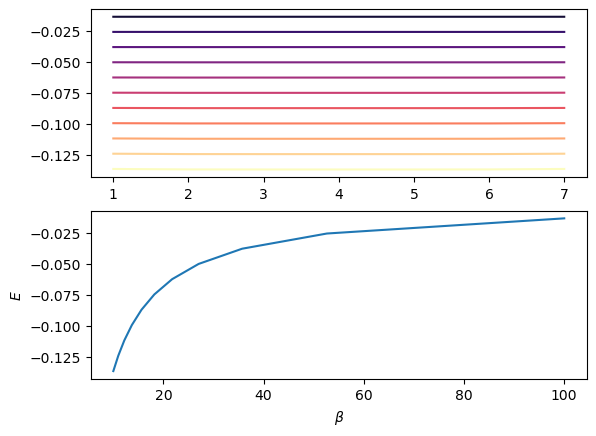

In [20]:
import matplotlib as mpl
cmap = mpl.colormaps['magma']

fig, ax = plt.subplots(2, 1)

for beta in beta_range:
    print(f"Beta: {beta}")
    working_state = copy.deepcopy(inf_T_state)
    beta_state = thf.finite_T_thermofield(beta, N, D, H_tf, 
                                          initial_state=working_state,
                                          plot=False, 
                                          method=sim.method_exact)[0]
    local_energies = [ops.local_expect(beta_state, term)/2 for term in H_terms] #remember factor of 2 for thermofield
    
    energies[beta] = np.mean(local_energies[int(N/4):int(3*N/4)])  # Average over the middle half of the chain
    print(f"Energy: {energies[beta]}")
    ax[0].plot(np.arange(1, N), local_energies, 
               color=cmap(beta/beta_max))


ax[1].plot(1/beta_range, list(energies.values()))
ax[1].set_xlabel(r"$\beta$")
ax[1].set_ylabel(r"$E$")



In [44]:
(energies[beta_max]/beta_max)

(-1.3656515655644974-5.297619015463828e-18j)

In [2]:
J=1
h=0.25
g=-0.525
print((J**2 + 0.5*(h**2 + g**2)))

1.1690625


Testing how long 'thermal' state stays looking normal before instabilities go crazy


In [ ]:
N = 10
D = 12
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_terms = ops.extensive_as_terms(H_tf).values()

inf_t_state = sim.inf_T_thermofield_variational(N, D, 1000, 10, seed=1)

Intial energy: (-9.922773922445385-1.953190213733015e-16j)
Initiating TDVP
TDVP finished!
Final energy: (-30.00000000000002+2.9143354390811245e-15j)


Initiating TDVP
TDVP finished!
Energy at finite temperature: -1.2567414422131788


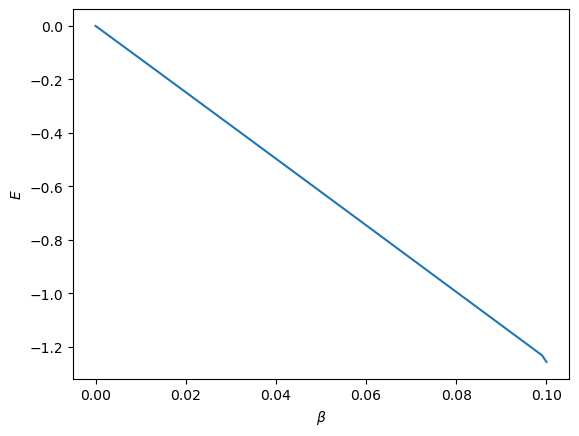

In [12]:
beta = 0.1
beta_state = thf.finite_T_thermofield(beta, N, D, H_tf, initial_state=inf_t_state)[0]

In [14]:
initial_state = copy.deepcopy(beta_state)
t_f = 1
n_steps = 50
# evolved_state, expectations = sim.tdvp(initial_state, H_tf, t_f, n_steps, operators=local_ops)
evolved_state, expectations = sim.tdvp(initial_state,
                                       H_tf, 
                                       t_f, 
                                       n_steps, 
                                       sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_tf])


Initiating TDVP
t: 0.000
t: 0.020
t: 0.040
t: 0.060
t: 0.080
t: 0.100
t: 0.120
t: 0.140
t: 0.160
t: 0.180
t: 0.200
t: 0.220
t: 0.240
t: 0.260
t: 0.280
t: 0.300
t: 0.320
t: 0.340
t: 0.360
t: 0.380
t: 0.400
t: 0.420
t: 0.440
t: 0.460
t: 0.480
t: 0.500
t: 0.520
t: 0.540
t: 0.560
t: 0.580
t: 0.600
t: 0.620
t: 0.640
t: 0.660
t: 0.680
t: 0.700
t: 0.720
t: 0.740
t: 0.760
t: 0.780
t: 0.800
t: 0.820
t: 0.840
t: 0.860
t: 0.880
t: 0.900
t: 0.920
t: 0.940
t: 0.960
t: 0.980
t: 1.000
TDVP finished!


c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


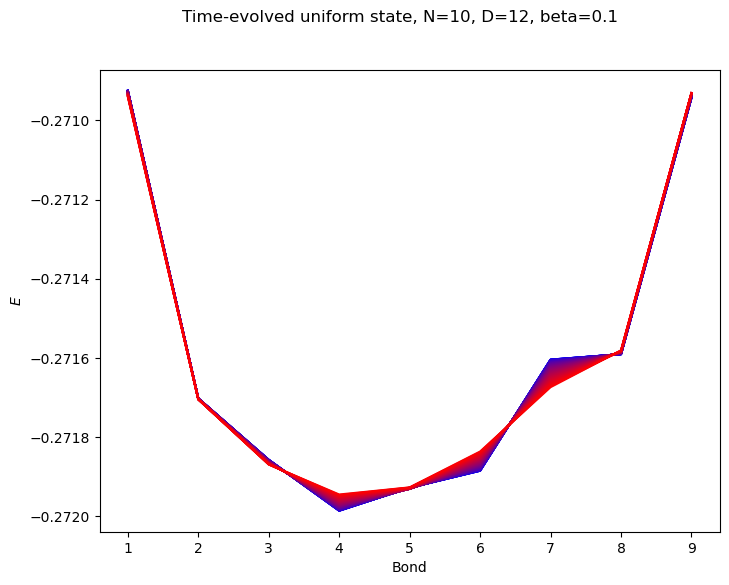

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle(f"Time-evolved uniform state, N={N}, D={D}, beta={beta}")

ax.set_ylabel(r'$E$')
ax.set_xlabel("Bond")

times = evolved_state.keys()
E_profile={}
for t in times:
    if t < t_f:
        E_profile[t] = [ops.local_expect(evolved_state[t], term)
                        for term in H_terms]
        ax.plot(np.arange(1,N), E_profile[t], color=(t/t_f, 0, 1-t/t_f))



### Deforming state with a different generator

The first order change of local energy density with time is zero identically for our state ansatz.

If we perturb with a different Hamiltonian this condition doesn't necessarily hold.


In [ ]:
N = 24
D = 10

H = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H)
H_terms = ops.extensive_as_terms(H_tf).values()
H_middle = H_terms[int((N-1)/2)]
H_perturb = ops.tilted_ising(J=0.1, h=1, g=0.01, N=N)
H_perturb_tf = thf.thermofield_hamiltonian(H_perturb)

In [3]:
inf_t_state = sim.inf_T_thermofield_variational(N, D, 1000, 10, seed=1)

Intial energy: (-23.31786888904933-7.809521800940295e-15j)
Final energy: (-71.99999901128606+8.32707502533862e-17j)


Energy at finite temperature: -0.3121676084946185


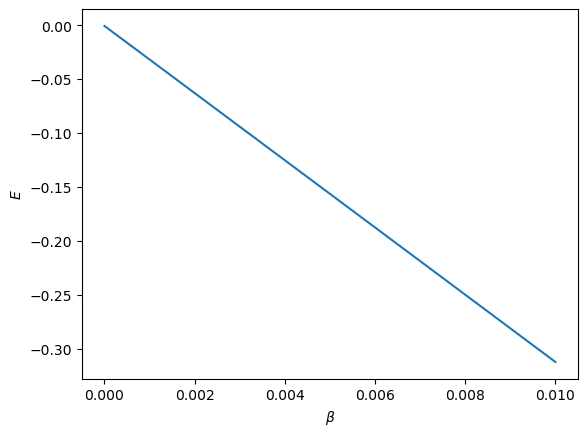

In [4]:
beta = 0.01
beta_state = thf.finite_T_thermofield(beta, N, D, H_tf,
                                      initial_state=inf_t_state)[0]

In [ ]:
working_state = copy.deepcopy(beta_state)
gamma_amp = 0.001
k = 0.8
gamma_profile = gamma_amp*np.cos(np.linspace(-N/2, N/2, N) * k)
gamma_profile = gamma_profile + 1.01*gamma_amp*np.ones(N)

gamma_state = thf.near_thermal(H_perturb_tf, gamma_profile, D, initial_state=working_state)

c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


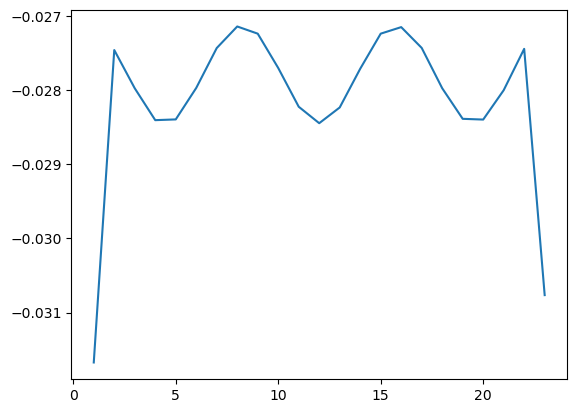

In [6]:
# vis.plot_energy_density(gamma_state, H_terms)

fig, ax = plt.subplots(1,1)
energy_density = [ops.local_expect(gamma_state, term) for term in H_terms]
ax.plot(list(gamma_state.sites)[:-1], energy_density)

In [7]:
t_f = 1
n_steps = 200
evolved_state, expectations = sim.tdvp(copy.deepcopy(gamma_state),
                                       H_tf, 
                                       t_f=t_f, 
                                       steps=n_steps, 
                                       method=sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_middle])

Initiating TDVP
t: 0.000
t: 0.005
t: 0.010
t: 0.015
t: 0.020
t: 0.025
t: 0.030
t: 0.035
t: 0.040
t: 0.045
t: 0.050
t: 0.055
t: 0.060
t: 0.065
t: 0.070
t: 0.075
t: 0.080
t: 0.085
t: 0.090
t: 0.095
t: 0.100
t: 0.105
t: 0.110
t: 0.115
t: 0.120
t: 0.125
t: 0.130
t: 0.135
t: 0.140
t: 0.145
t: 0.150
t: 0.155
t: 0.160
t: 0.165
t: 0.170
t: 0.175
t: 0.180
t: 0.185
t: 0.190
t: 0.195
t: 0.200
t: 0.205
t: 0.210
t: 0.215
t: 0.220
t: 0.225
t: 0.230
t: 0.235
t: 0.240
t: 0.245
t: 0.250
t: 0.255
t: 0.260
t: 0.265
t: 0.270
t: 0.275
t: 0.280
t: 0.285
t: 0.290
t: 0.295
t: 0.300
t: 0.305
t: 0.310
t: 0.315
t: 0.320
t: 0.325
t: 0.330
t: 0.335
t: 0.340
t: 0.345
t: 0.350
t: 0.355
t: 0.360
t: 0.365
t: 0.370
t: 0.375
t: 0.380
t: 0.385
t: 0.390
t: 0.395
t: 0.400
t: 0.405
t: 0.410
t: 0.415
t: 0.420
t: 0.425
t: 0.430
t: 0.435
t: 0.440
t: 0.445
t: 0.450
t: 0.455
t: 0.460
t: 0.465
t: 0.470
t: 0.475
t: 0.480
t: 0.485
t: 0.490
t: 0.495
t: 0.500
t: 0.505
t: 0.510
t: 0.515
t: 0.520
t: 0.525
t: 0.530
t: 0.535
t: 0.540
t: 

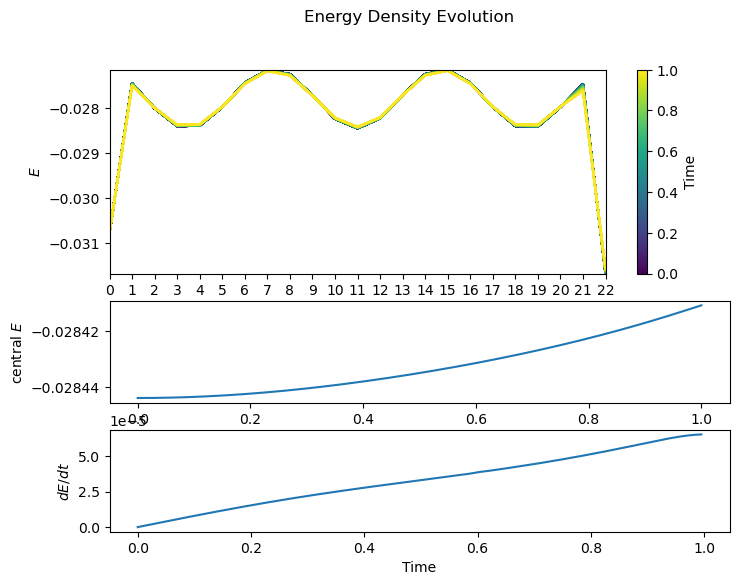

In [8]:
vis.plot_energy_density_evolution(evolved_state, H_terms, 1.0)

In [11]:
# further evolution
new_init_state = copy.deepcopy(evolved_state[t_f])

t_f = 1
n_steps = 200
new_evolved_state, expectations = sim.tdvp(copy.deepcopy(new_init_state),
                                       H_tf, 
                                       t_f=t_f, 
                                       steps=n_steps, 
                                       method=sim.method_exact,
                                       history=True, 
                                       verbose=True, 
                                       operators=[H_middle])

Initiating TDVP
t: 0.000
t: 0.005
t: 0.010
t: 0.015
t: 0.020
t: 0.025
t: 0.030
t: 0.035
t: 0.040
t: 0.045
t: 0.050
t: 0.055
t: 0.060
t: 0.065
t: 0.070
t: 0.075
t: 0.080
t: 0.085
t: 0.090
t: 0.095
t: 0.100
t: 0.105
t: 0.110
t: 0.115
t: 0.120
t: 0.125
t: 0.130
t: 0.135
t: 0.140
t: 0.145
t: 0.150
t: 0.155
t: 0.160
t: 0.165
t: 0.170
t: 0.175
t: 0.180
t: 0.185
t: 0.190
t: 0.195
t: 0.200
t: 0.205
t: 0.210
t: 0.215
t: 0.220
t: 0.225
t: 0.230
t: 0.235
t: 0.240
t: 0.245
t: 0.250
t: 0.255
t: 0.260
t: 0.265
t: 0.270
t: 0.275
t: 0.280
t: 0.285
t: 0.290
t: 0.295
t: 0.300
t: 0.305
t: 0.310
t: 0.315
t: 0.320
t: 0.325
t: 0.330
t: 0.335
t: 0.340
t: 0.345
t: 0.350
t: 0.355
t: 0.360
t: 0.365
t: 0.370
t: 0.375
t: 0.380
t: 0.385
t: 0.390
t: 0.395
t: 0.400
t: 0.405
t: 0.410
t: 0.415
t: 0.420
t: 0.425
t: 0.430
t: 0.435
t: 0.440
t: 0.445
t: 0.450
t: 0.455
t: 0.460
t: 0.465
t: 0.470
t: 0.475
t: 0.480
t: 0.485
t: 0.490
t: 0.495
t: 0.500
t: 0.505
t: 0.510
t: 0.515
t: 0.520
t: 0.525
t: 0.530
t: 0.535
t: 0.540
t: 

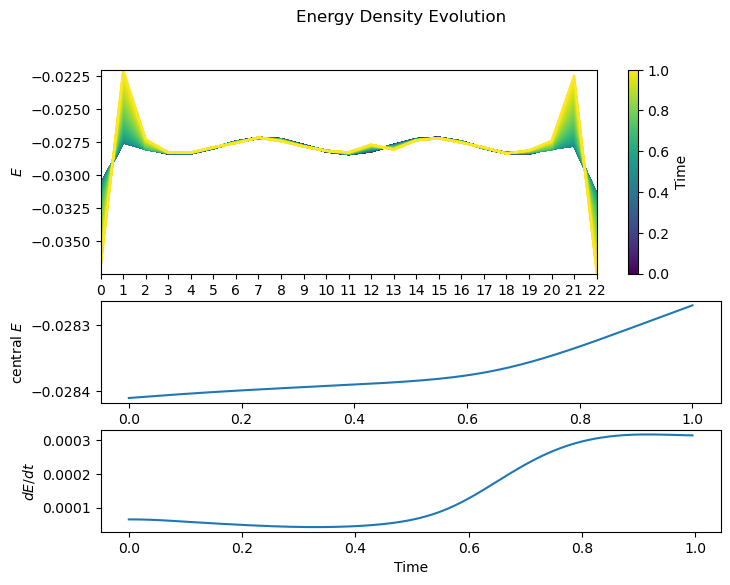

In [12]:
vis.plot_energy_density_evolution(new_evolved_state, H_terms, 1.0)

## First order deformation saturation

Does the first order deformation lead to saturation of current? In principle the expression is only accurate in the small $t$ limit, but what if we extend this a long way? 

We have the expresion for the density matrix evolution 

$$ \frac{d\rho}{dt} = -i[H, \rho] \rightarrow \rho(t) = \rho(0) - i t [H, \rho(0)] + \mathcal{O}(t^2)$$

At high temperatures $\beta \ll 1$ the ansatz density matrix is simple: $\rho(0) = \frac 1 Z (1 -\beta_ih_i) +\mathcal{O}(\beta^2) $. As such,

$$ \rho(t) = \frac 1 Z (1 - \beta_i (h_i - i t [H, h_i]))+ \mathcal{O}(\beta^2, t^2)$$

The deformed state is the ansatze state with the same temperature profile but a new less local Hamiltonian. 

Note that the commutator is trace zero, so does not affect the normalisation $Z$.


In [6]:
D = 16
N = 24
k = 0.5
beta_avg = 0.1
beta_amp = 0.01
beta_profile = beta_amp*np.cos(np.linspace(-N/2, N/2, N) * k) + beta_avg*np.ones(N)
H_usual = ops.tilted_ising(N=N)
H_tf = thf.thermofield_hamiltonian(H_usual)
H_terms = ops.extensive_as_terms(H_tf)


In [7]:
state = thf.near_thermal_first_order_deformed(D, beta_profile, t=10)

Intial energy: (-23.677755292123273-7.870765671158923e-15j)
Final energy: (-72.00000000000004+1.915134717478395e-15j)


c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\osolomonstuke\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


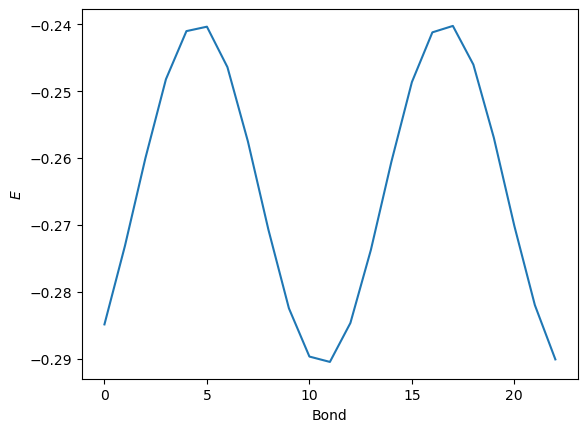

In [8]:
vis.plot_energy_density(state, H_terms.values())

In [11]:
np.real(ops.dhi_dt(state, 11))

0.00022041853499222647

### Testing wavelength dependence


C:\Users\osolomonstuke\AppData\Local\Temp\ipykernel_27344\2784234807.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
2.4620634077216654e-05
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
0.00024621782349698265
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
0.0004925214642573156
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
0.0007389954117375442
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
4.1290998766559724e-05
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
0.00041297547036072064
Intial energy: (-23.73260496968164+1.1752480499199494e-15j)
Final energy: (-72.00000000000006-3.219646771412954e-15j)
0.0008263277189557513
Intial energy: (

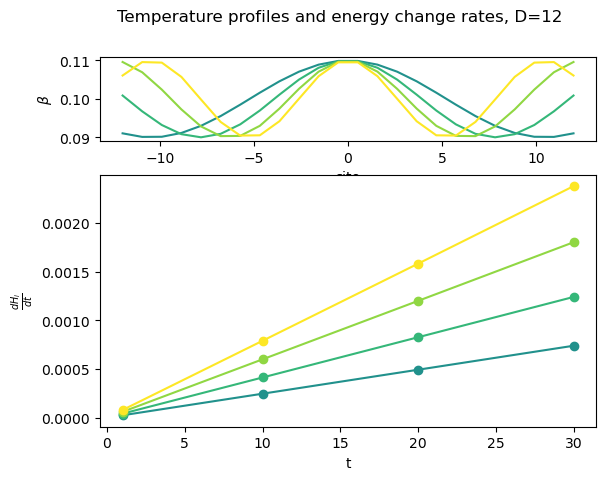

In [19]:
import matplotlib.cm as cm
cmap = cm.get_cmap('viridis')

D = 12
N = 24
beta_avg = 0.1
beta_amp = 0.01

k_rates = {}
times = [1, 10, 20, 30]
wavevectors = [0.3, 0.4, 0.5, 0.6]

fig, ax = plt.subplots(2,1, height_ratios=[1,3])
fig.suptitle(f"Temperature profiles and energy change rates, D={D}")
ax[0].set_xlabel('site')
ax[0].set_ylabel(r'$\beta$')
ax[1].set_xlabel("t")
ax[1].set_ylabel(r"$\frac{dH_i}{dt}$")

for k in wavevectors:
    c = k / max(wavevectors)
    rates = {}
    beta_profile = beta_amp*np.cos(np.linspace(-N/2, N/2, N) * k) + beta_avg*np.ones(N)
    ax[0].plot(np.linspace(-N/2, N/2, N), beta_profile, label=f"k={k:.2f}", color=cmap(c))

    H_usual = ops.tilted_ising(N=N)
    H_tf = thf.thermofield_hamiltonian(H_usual)
    H_terms = ops.extensive_as_terms(H_tf)
    for t in times:
        state = thf.near_thermal_first_order_deformed(D, beta_profile, t=t, steps=50)
        rates[t] = np.real(ops.dhi_dt(state, N/2))
        print(rates[t])
    rate = list(rates.values())
    t = list(rates.keys())
    ax[1].plot(t, np.real(rate), marker='o', color=cmap(c), label=f"k={k:.2f}")

Text(0, 0.5, '$\\frac{dH_i}{dt}$')

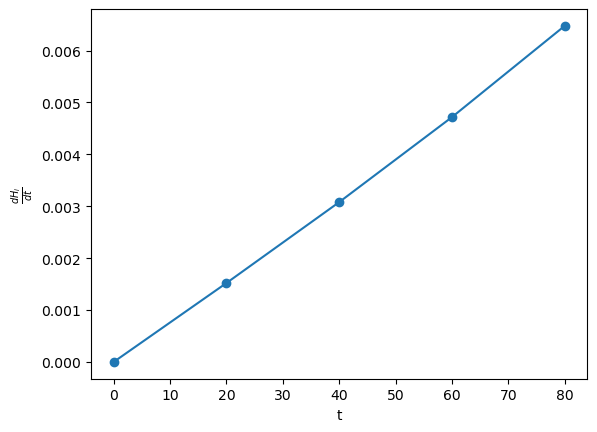

In [ ]:

rate = list(rates.values())
ax.plot(t, np.real(rate), marker='o')
ax.set_xlabel("t")
ax.set_ylabel(r"$\frac{dH_i}{dt}$")

c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\charl\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


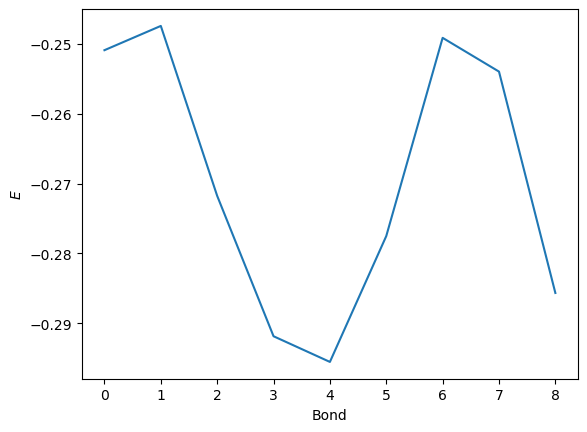

In [22]:
vis.plot_energy_density(state, H_terms.values())

In [24]:
Dl = 5
Dr = 7
L = 11

LL = np.random.rand(Dl, Dl, L)
RR = np.random.rand(Dr, Dr, L)
A = np.random.rand(2, Dl, Dr)
O = np.random.rand(2, 2, L, L)

pathinfo = np.einsum_path('abc,def,gad,ghcf->hbe', LL, RR, A, O, optimize='greedy')

In [25]:
print(pathinfo[1])

  Complete contraction:  abc,def,gad,ghcf->hbe
         Naive scaling:  8
     Optimized scaling:  8
      Naive FLOP count:  2.372e+06
  Optimized FLOP count:  2.372e+06
   Theoretical speedup:  1.000
  Largest intermediate:  7.000e+01 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   8       ghcf,gad,def,abc->hbe                                 hbe->hbe


In [33]:
import numpy as np

M = np.random.rand(2, 5)
N = np.random.rand(5,6)
np.shape(M@N)

(2, 6)

In [6]:
import qtensor.states as states

N=10
d=2
D=128
psi1 = states.random_mps(N, d, D, seed=0)
psi2 = states.random_mps(N, d, D, seed=2)

print(states.overlap(psi1, psi1))


(0.007465143696785848-1.3552527156068805e-20j)


In [7]:
psi1.left_orthogonal()
psi2.right_orthogonal()

In [8]:
print(states.overlap(psi1, psi1))
print(states.overlap(psi2, psi2))
print(states.overlap(psi1, psi2))
print(states.overlap(psi2, psi1))

(1.0000000000000002+1.8355161642290048e-17j)
(1.0000000000000009+1.387778780781447e-17j)
(0.01590046028156924+0.01288025251953926j)
(0.015900460281569318-0.012880252519539215j)


In [9]:
print(psi1.sites)
print([psi1[i].shape[1] for i in psi1.sites])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2, 2, 4, 8, 16, 32, 64, 128, 128, 128]
